In [1]:
import pandas as pd
import numpy as np
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import os

In [2]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
regions = ['xisanqi', 'qinghe', 'xierqi', 'shangdi']
data_rows = []

In [4]:
def remove_2d_outliers(df, x_col, y_col, contamination=0.05):
    """二维异常值过滤（椭圆包络法）"""
    data = df[[x_col, y_col]].dropna()
    if len(data) < 10:  # 当数据量过小时跳过过滤
        return df
    model = EllipticEnvelope(contamination=contamination, random_state=42)
    inliers = model.fit_predict(data) == 1
    return df.loc[data[inliers].index]

In [5]:
# 创建保存清洗数据的目录
output_dir = 'C:/Users/86138/Tigercut/Homework_3/cleaned_data/'
os.makedirs(output_dir, exist_ok=True)  # 自动创建目录（如果不存在）

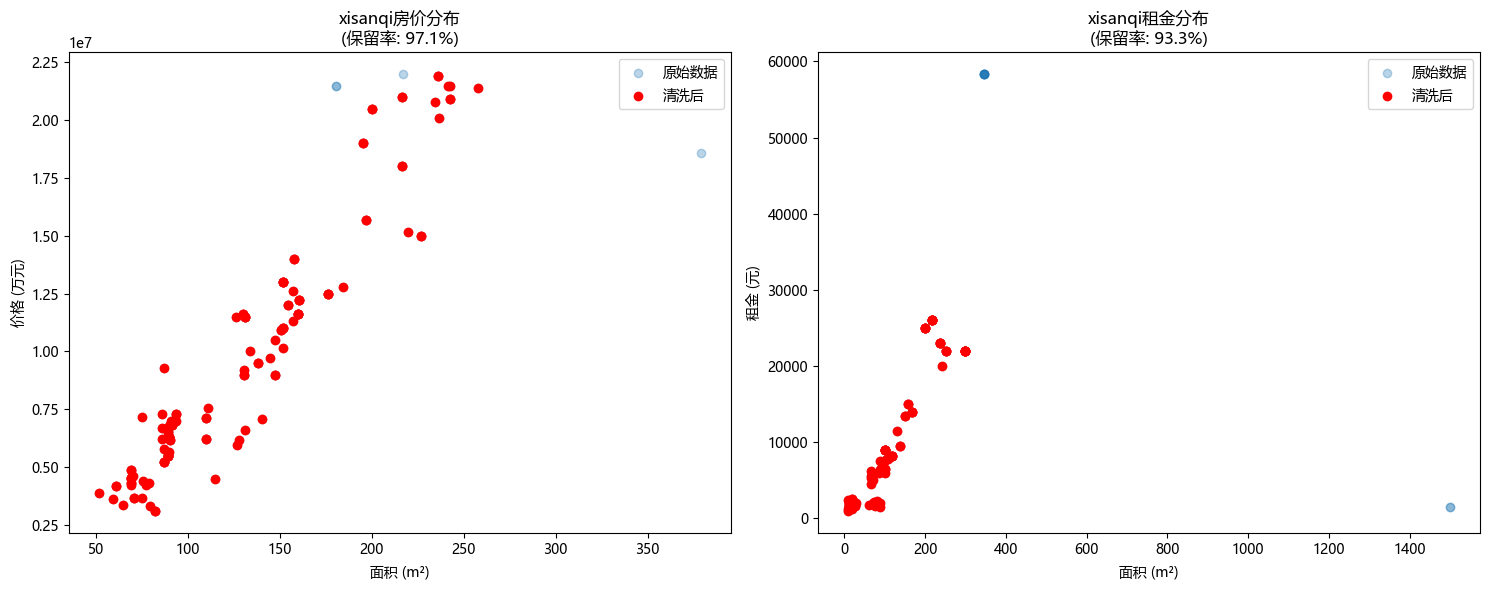

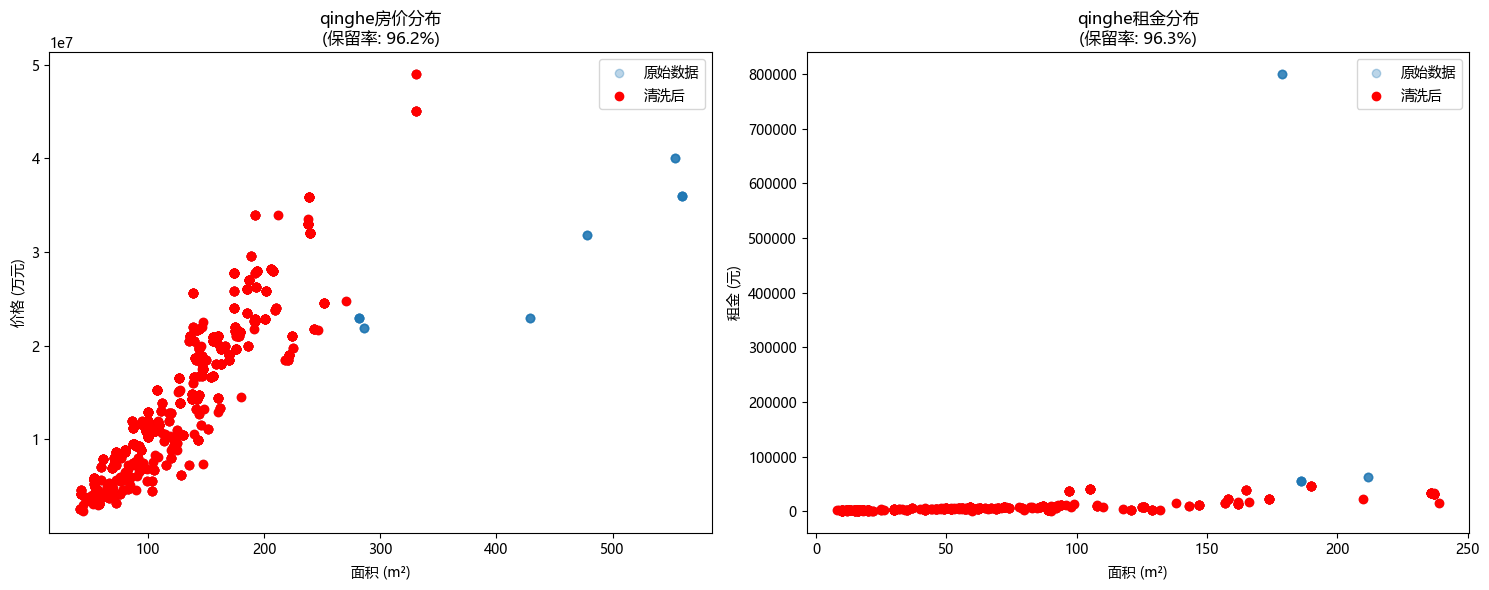

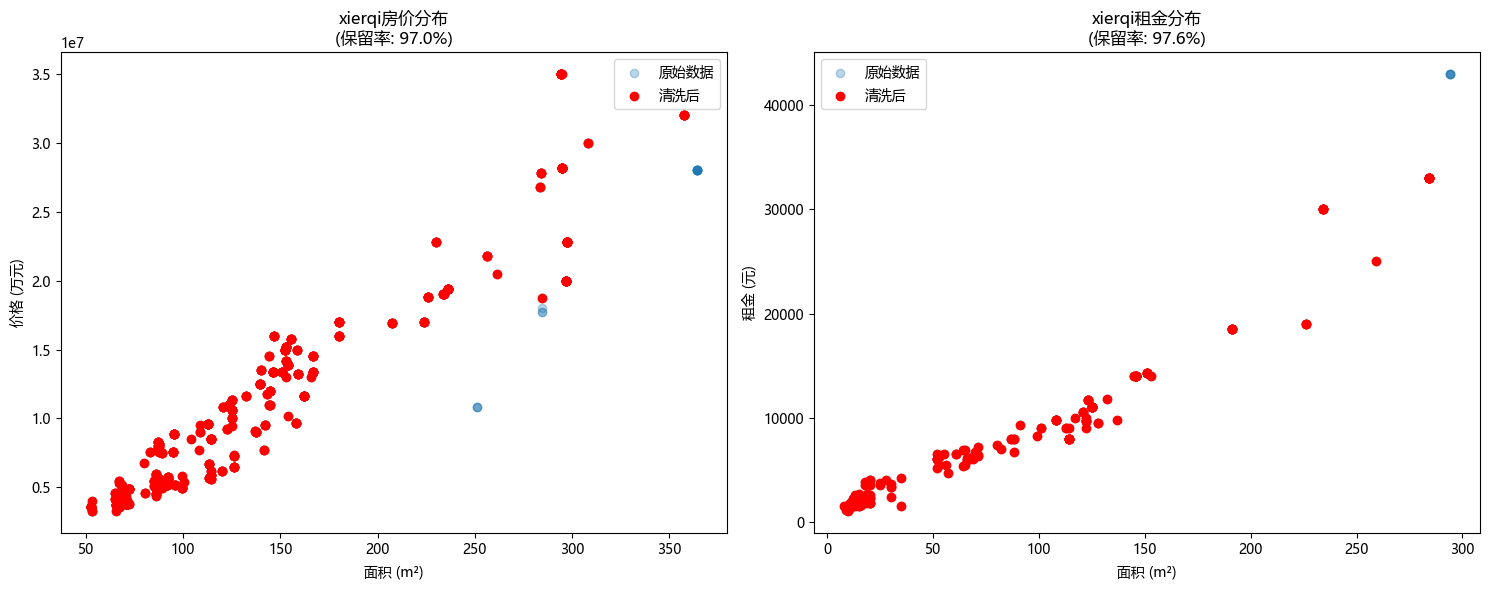

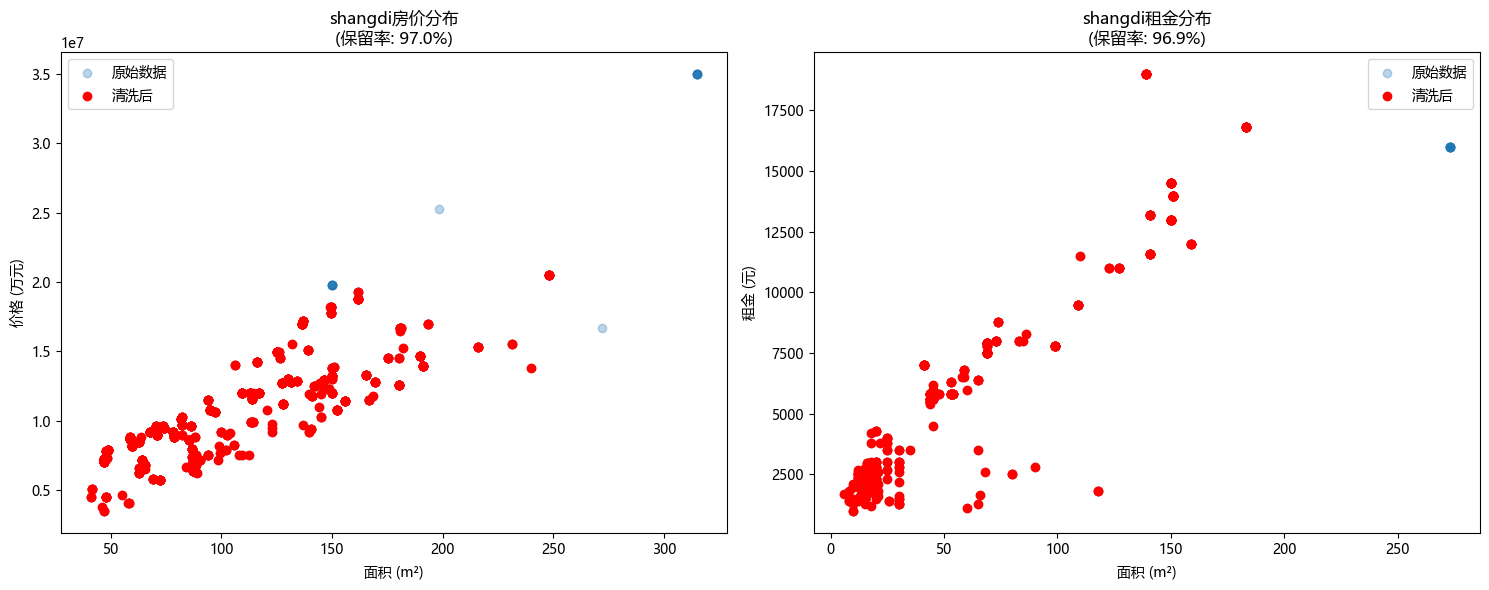

In [6]:
# 循环处理每个区域
for region in regions:
    # 读取原始数据
    housing = pd.read_csv(f'C:/Users/86138/Tigercut/Homework_3/data/{region}_housing.csv')
    renting = pd.read_csv(f'C:/Users/86138/Tigercut/Homework_3/data/{region}_renting.csv')

    # 数据清洗
    housing_clean = remove_2d_outliers(housing, 'm2', 'price', contamination=0.03)
    renting_clean = remove_2d_outliers(renting, 'm2', 'rent', contamination=0.03)

    # 保存清洗后的数据
    housing_clean.to_csv(f'{output_dir}{region}_housing_clean.csv', index=False)
    renting_clean.to_csv(f'{output_dir}{region}_renting_clean.csv', index=False)
    
    # 指标计算（使用清洗后数据）
    price_per_m2 = housing_clean['price'].median() / housing_clean['m2'].median()
    rent_per_m2 = renting_clean['rent'].median() / renting_clean['m2'].median()
    ratio = price_per_m2 / rent_per_m2
    
    # 记录清洗效果
    retention_rate = {
        'housing': len(housing_clean)/len(housing),
        'renting': len(renting_clean)/len(renting)
    }
    
    # 保存结果
    data_rows.append({
        'region': region,
        'price_per_m2': round(price_per_m2, 2),
        'rent_per_m2': round(rent_per_m2, 2),
        'ratio': round(ratio, 2),
        'housing_retention': f"{retention_rate['housing']:.1%}",
        'renting_retention': f"{retention_rate['renting']:.1%}"
    })

    # 可视化当前区域清洗效果
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # 房价清洗效果
    ax[0].scatter(housing['m2'], housing['price'], alpha=0.3, label='原始数据')
    ax[0].scatter(housing_clean['m2'], housing_clean['price'], color='red', label='清洗后')
    ax[0].set_title(f'{region}房价分布\n(保留率: {retention_rate["housing"]:.1%})')
    ax[0].set_xlabel('面积 (m²)')
    ax[0].set_ylabel('价格 (万元)')
    ax[0].legend()
    
    # 租金清洗效果
    ax[1].scatter(renting['m2'], renting['rent'], alpha=0.3, label='原始数据')
    ax[1].scatter(renting_clean['m2'], renting_clean['rent'], color='red', label='清洗后')
    ax[1].set_title(f'{region}租金分布\n(保留率: {retention_rate["renting"]:.1%})')
    ax[1].set_xlabel('面积 (m²)')
    ax[1].set_ylabel('租金 (元)')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

In [7]:
results = pd.DataFrame(data_rows)
results

,region,price_per_m2,rent_per_m2,ratio,housing_retention,renting_retention
0,xisanqi,57593.69,35.14,1639.20,97.1%,93.3%
1,qinghe,104608.63,92.31,1133.26,96.2%,96.3%
2,xierqi,77550.69,97.73,793.54,97.0%,97.6%
3,shangdi,99019.61,127.27,778.01,97.0%,96.9%


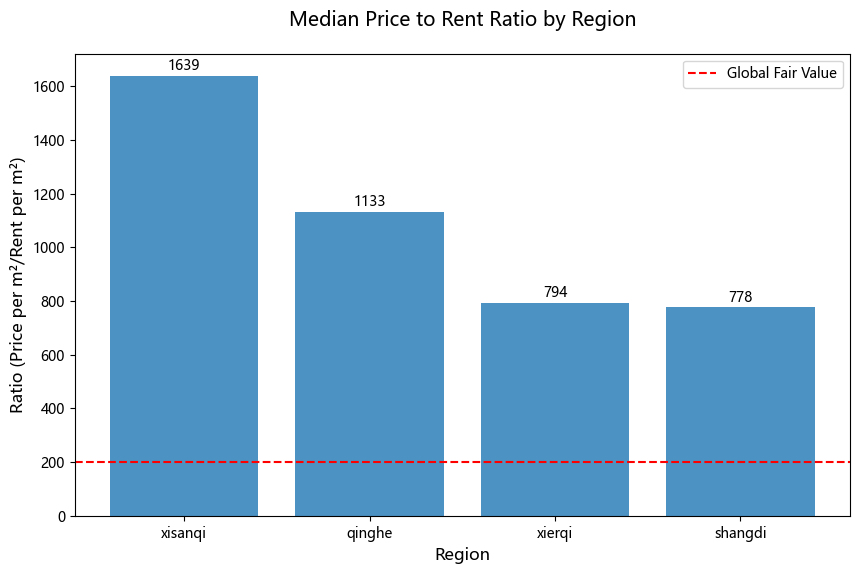

In [8]:
# 创建画布和坐标轴
plt.figure(figsize=(10, 6))
ax = plt.subplot()

# 绘制条形图
bars = ax.bar(
    results['region'], 
    results['ratio'],
    color='#1f77b4',  # 修改颜色（可选）
    alpha=0.8
)

# 添加全局合理值参考线（200）
ax.axhline(y=200, color='red', linestyle='--', linewidth=1.5, label='Global Fair Value')

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + 5,  # 标签位置微调
        f'{height:.0f}',  # 显示整数
        ha='center', 
        va='bottom'
    )

# 设置标题和标签
ax.set_title('Median Price to Rent Ratio by Region', fontsize=14, pad=20)
ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Ratio (Price per m²/Rent per m²)', fontsize=12)
ax.legend(loc='upper right')

# 显示图形
plt.show()